![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Foundations of Soil Mechanics**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/fakultaet3/gt/soilmechanics


# Kinematische Elemente Methode

In [187]:
import numpy as np #numerical methods
import matplotlib.pyplot as plt #plotting
import pandas as pd

#Some plot settings
import plot_functions.plot_settings
%run plot_functions/KEM_plots.ipynb

Wir definieren zunächst die Geometrie des Problems, legen also die kinematischen Elemente des Bruchmechanismus fest.

In [188]:
geometry = pd.DataFrame(np.array([[1,2,3,4,5,6,7,8,9],
                                  [6.9,5.5,4.63,5.88,4.6,3.78,2.5,2.36,0.0],
                                  [4.0,4.0,2.84,1.68,-0.2,1.71,0.0,-1.1,0.0]]).T,
                   columns=['Pkt', 'x / m', 'y / m'])
geometry

,Pkt,x / m,y / m
0,1.0,6.90,4.00
1,2.0,5.50,4.00
2,3.0,4.63,2.84
3,4.0,5.88,1.68
4,5.0,4.60,-0.20
5,6.0,3.78,1.71
6,7.0,2.50,0.00
7,8.0,2.36,-1.10
8,9.0,0.00,0.00


In [189]:
#Achtung: Nummerierung im Umlaufsinn!
block1 = define_element(geometry,[1,2,3,4])
block2 = define_element(geometry,[4,3,6,5])
block3 = define_element(geometry,[5,6,7,8])
block4 = define_element(geometry,[8,7,9])

In der Darstellung ergibt sich folgende Böschungsgeometrie.

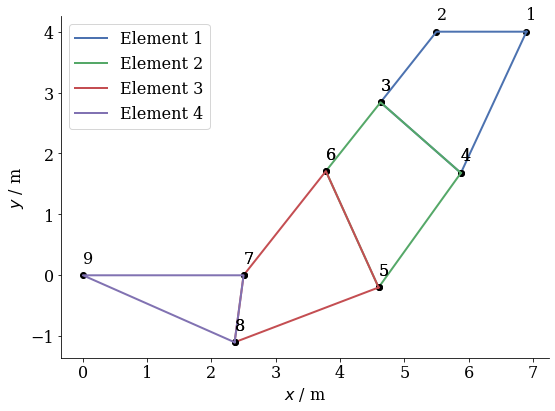

In [190]:
plot_blocks([block1,block2,block3,block4])

Jetzt können wir bereits einige wesentliche Größen ausrechnen. Genauer gesagt, können wir die Gewichtskräfte der einzelnen kinematischen Elemente aus ihren Flächeninhalten ableiten. Dazu legen wir die wesentlichen Materialeigenschaften fest.

In [191]:
#Wichte in kN/m³
gamma = 16.
#Kohäsion in kN/m²
c = 5
#Reibungswinkel in rad
phi = np.deg2rad(30)

In [192]:
data = {'A / m²': np.array([block_area(block1),block_area(block2),block_area(block3),block_area(block4)])} #in m

In [193]:
data['G / kN/m'] = data['A / m²']*gamma

In [194]:
blockdata = pd.DataFrame(data)
blockdata

,A / m²,G / kN/m
0,2.85360,45.6576
1,3.19245,51.0792
2,3.09250,49.4800
3,1.37500,22.0000


Am unteren Körper lässt sich direkt das Kräftegleichgewicht konstruieren: Wir kennen die Gewichtskraft sowie die Wirkungslinien der Reibungs- und Kohäsionskräfte in den beiden Gleitfugen. Der Richtungssinn der letzteren beiden Kräfte folgt aus dem Geschwindigkeitsplan. Außerdem sind die Normalenkräfte anzusetzen. Normalkraft $N$ und Reibungskraft $R$ werden zur Gleitfugenresultierenden $Q$ zuammengefasst und aus dem Kräftegleichgewicht bestimmt, während sich die Kohäsionskräfte $C$ aus dem Bruchmechanismus ableiten.

## Kräftegleichgewicht am Element 4

Sammeln wir zunächst die aus der Geometrie und den Materialeigenschaften bekannten Vektoren $\vec{G}_4$, $\vec{C}_{98}$ und $\vec{C}_{78}$. Dabei gelte an Grenzflächen die Konvention $\vec{F}_{\text{von}\,\text{bis}}$, wodurch über die Reihenfolge der Indizes die Wirkrichtung festgelegt ist.

In [195]:
G_4 = gravity_vector(blockdata,4)
G_4

array([  0., -22.])

In [229]:
C_98 = cohesion(c,geometry,9,8)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_98))
C_98

Die Kohäsionskraft beträgt 13.02 kN/m


array([11.8, -5.5])

In [230]:
C_78 = cohesion(c,geometry,7,8)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_78))
C_78

Die Kohäsionskraft beträgt 5.54 kN/m


array([-0.7, -5.5])

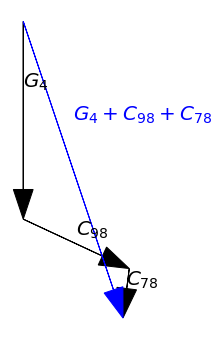

In [208]:
scale = np.linalg.norm(G_4)
fig, ax = plt.subplots()
vec_from_by(ax,delta=G_4,label='$G_4$',scale=scale)
vec_from_by(ax,fro=G_4,delta=C_98,label='$C_{98}$',scale=scale)
vec_from_by(ax,fro=G_4+C_98,delta=C_78,label='$C_{78}$',scale=scale)
vec_from_by(ax,delta=G_4+C_98+C_78,label='$G_4 + C_{98} + C_{78}$',scale=scale,col='blue')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Ausgehend von der Wirkungsrichtung von $\vec{C}_{\text{von}\,\text{bis}}$ ergibt sich die Wirkungsrichtung der Gleitfugenresultierenden $\vec{Q}_{\text{von}\,\text{bis}}$ durch Rotation um $90° - \varphi$ gegen den Uhrzeigersinn (mathematisch positiv), da $\vec{Q}$ gegenüber dem Lot auf die Gleitfläche (Wirkungslinie von $\vec{N}$) um den Reibungswinkel $\varphi$ geneigt ist und ebenso wie $\vec{C}$ der Bewegung des Gleitkörpers entgegen wirkt.

Zur Rotation von Vektoren wird die Rotationsmatrix $R$ festgelegt:

In [226]:
beta = np.deg2rad(90) - phi
R = np.array([[np.cos(beta),-np.sin(beta)],[np.sin(beta),np.cos(beta)]])
R

array([[ 0.5      , -0.8660254],
       [ 0.8660254,  0.5      ]])

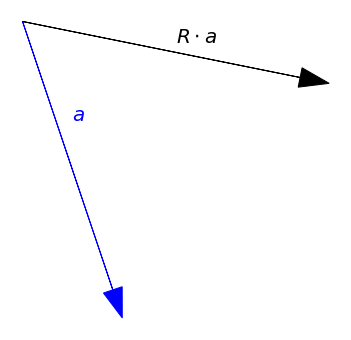

In [228]:
scale = np.linalg.norm(G_4)
fig, ax = plt.subplots()
a= G_4+C_98+C_78
vec_from_by(ax,delta=a,label='$a$',scale=scale,col='blue')
vec_from_by(ax,delta=R.dot(a),label='$R \cdot a$',scale=scale)
ax.set(adjustable='box', aspect='equal')
plt.axis('off');